# Find best GRB candidates

Find in a population file the candidates fullfilling the user requirements

In [1]:
import gammapy
gammapy.__version__

'0.18.2'

In [2]:
import os, sys

popfolder = "../population" 
sys.path.append(popfolder) 

import setup

import init as init
import numpy as np
from utilities import MyLabel
from utilities import stamp, Log
from pop_plot import col_size, sig_legend, history, plot_historical, redshift, eiso


import matplotlib.pyplot as plt

plt.style.use('seaborn-talk') # Make the labels readable
#plt.style.use('seaborn-poster') # Make the labels readable - bug with normal x marker !!!

## Read data - create the total population - infer detection level

In [3]:
# Open data, get population
file = init.create_csv(debug=False)
(grb, gn0, gs0, gn, gs, gb) = init.get_data(file, debug=False)

# Effective det_level
eff_lvl = init.get_eff_lvl(grb)

import pandas as pd
fullpop = pd.concat([gn0,gs0,gb],axis=0)
len(fullpop)

611

## Reference population

In [4]:
popref   = grb[grb.site=="North"] # Get initial population (restrict ot one of N, S, B)
popNS    = grb[(grb.site=="North") | (grb.site=="South")]
len(popNS)

2000

## Select subpopulation from some criteria

In [5]:
pop0 = popNS[popNS.sigmx>=3]
sigmx_min = 50
sigmx_max = 1200
nslice_min = 0
nslice_max = 8
z_min = 1.5
z_max= 10

mask_slice = (pop0.nt>= nslice_min) & (pop0.nt <= nslice_max)
mask_sigmx = (pop0.sigmx >= sigmx_min) & (pop0.sigmx <= sigmx_max)
mask_z = (pop0.z >= z_min) & (pop0.z <= z_max)
mask = mask_slice & mask_sigmx & mask_z
selected = pop0[mask]

In [6]:
print(" Selected candidates = ",len(selected))
for index, g in selected.iterrows():
    print("{:4} {:8s} {:5s} nt={:3} sigmx={:8.1f}   z={:3.2f}   Eiso={:3.1e}"
          .format(index, g["name"],g.site,g.nt,g.sigmx,g.z,g.Eiso))

 Selected candidates =  2
1392 Event465 North nt=  6 sigmx=   137.6   z=1.72   Eiso=6.2e+54
1393 Event465 South nt=  5 sigmx=    77.6   z=1.72   Eiso=6.2e+54


In [7]:
## Show variable correlations

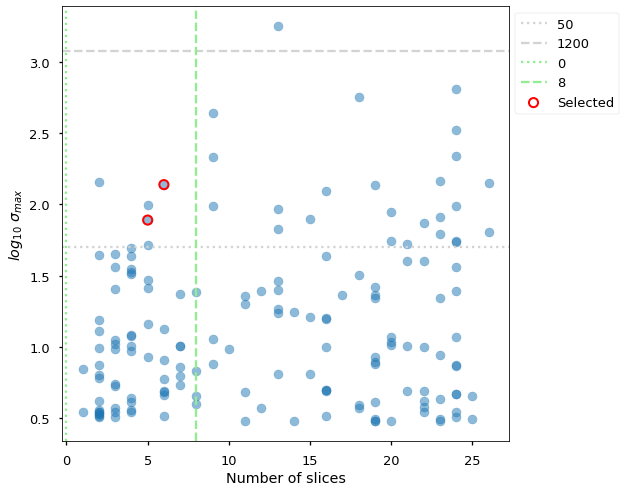

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.scatter(pop0.nt,np.log10(pop0.sigmx),alpha=0.5,color="tab:blue")
ax.scatter(selected.nt,np.log10(selected.sigmx),alpha=1,edgecolor="red",facecolor="none",lw=2,label="Selected")
ax.axhline(np.log10(sigmx_min),ls=":",color="lightgrey",label=str(sigmx_min))
ax.axhline(np.log10(sigmx_max),ls="--",color="lightgrey",label=str(sigmx_max))
ax.axvline(nslice_min,ls=":",color="lightgreen",label=str(nslice_min))
ax.axvline(min(max(pop0.nt),nslice_max),ls="--",color="lightgreen",label=str(nslice_max))
ax.set_xlabel("Number of slices")
ax.set_ylabel("$log_{10} \ \sigma_{max}$")
ax.legend(bbox_to_anchor=[1,1])


# <font color="#FF0000">CHECK nt versus detection and why 2 populations</font>

## Show selected GRBs among their friends

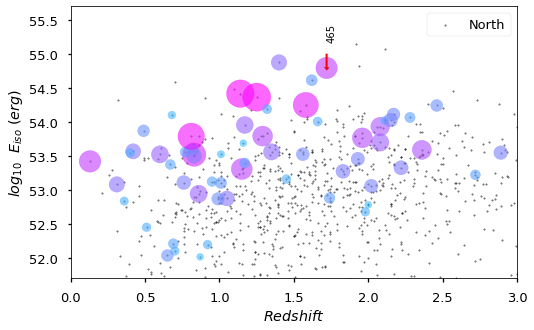

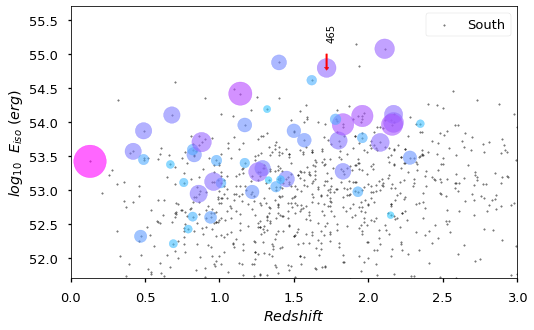

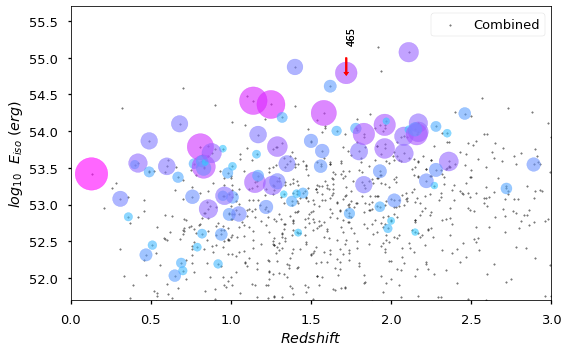

In [10]:
### -----------------------
### Loop over population
zlimit  = 7
Eisomin = 5e51
Eisomax = 5e55
zmin = 0
zmax = 3

### -----------------------
taglist  = ["North", "South", "Combined"]
# masklist = [gn.d5s>=eff_lvl, gs.d5s>=eff_lvl,fullpop.d5s>=eff_lvl]
masklist = [gn.d3s>=eff_lvl, gs.d3s>=eff_lvl,fullpop.d3s>=eff_lvl]
poplist  = [gn,gs,fullpop]

# title = "Detected at $5\sigma \ (90\% \ C.L.)$"
title = "Detected at $3\sigma \ (90\% \ C.L.)$"

# fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(8,5*len(taglist)),sharex=True)
# for ax0, pop, mask, tag in zip(ax, poplist, masklist, taglist):
for pop, mask, tag in zip(poplist, masklist, taglist):
    fig,ax0 = plt.subplots(nrows=1,ncols=1,figsize=(8,5),sharex=False)

    # Generated population
    ax0.scatter(popref.z, np.log10(popref.Eiso),
                marker=".", color="black",s=10, alpha=0.5, label=tag)

    # Detected population
    colors, sizes = col_size(pop[mask].sigmx)
    ax0.scatter(pop[mask].z, np.log10(pop[mask].Eiso),
                marker="o", s= sizes, c=colors, alpha = 0.6)

    # Pinpoint selected
    patches=[]
    for index, g in selected.iterrows():
        if g.site == tag or tag=="Combined":
            ax0.arrow(g.z,55,0,0.95*(-55+np.log10(g.Eiso)),color="red",width=0.01)
            ax0.text(g.z,55.2, s=g["name"][5:],rotation=90)

    # Decoration
    ax0.set_xlim(xmin=zmin, xmax=zmax)
    ax0.set_ylim(ymin=np.log10(Eisomin),ymax=np.log10(Eisomax))
    ax0.set_ylabel("$log_{10}$  $E_{iso}$ $(erg)$")
    ax0.legend()
    ax0.set_xlabel("$Redshift$")

# ax0.set_xlabel("$Redshift$")
plt.tight_layout()